# Config

In [1]:
import os

In [2]:
##### file system
INPUT_DIR = "/kaggle/input/audio-mnist/data"
WORKING_DIR = "/kaggle/working"

##### dataset
SAMPLE_RATE = 48_000
MAX_INPUT_SIZE = 65_536

##### training
TRAIN_PERCENTAGE = 0.8
BATCH_SIZE = 64
DATA_PERCENTAGE = 0.5

In [3]:
if not os.path.exists(WORKING_DIR):
    os.mkdir(WORKING_DIR)

# Explore Data

In [4]:
from tqdm import tqdm
from scipy.io import wavfile
import shutil
import matplotlib.pyplot as plt
import pandas as pd

## Prepare Data for PyTorch

I will be using PyTorch, to load a custom dataset it needs some fixing.

- I will create a csv file with information regarding all files

In [5]:
def create_csv_info():
    # initialize the dataset
    dataset = pd.DataFrame(columns=["file", "label", "speaker"])

    for speaker in tqdm(os.listdir(INPUT_DIR)):
        # check if "speaker" is a folder
        # "speaker" should be a folder with all the recordings from the given
        #   speaker, the name of the speaker is the name of the folder
        if not os.path.isdir(os.path.join(INPUT_DIR, speaker)):
            continue

        for file in os.listdir(os.path.join(INPUT_DIR, speaker)):
            label = file.split("_")[0]
            file_path = os.path.join(speaker, file)

            dataset = dataset.append({
                "file": file_path,
                "label": label,
                "speaker": speaker
            }, ignore_index=True)

    # write dataset as csv
    dataset.to_csv(os.path.join(WORKING_DIR, "dataset.csv"), index=False)

In [6]:
create_csv_info()

100%|██████████| 61/61 [01:18<00:00,  1.28s/it]


# Load Dataset

In [7]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np


In [8]:
class AudioSample():
    # this defines one audio sample
    def __init__(self, sample_rate, samples):
        self.sample_rate = sample_rate
        self.samples = samples

    def display(self):
        plt.plot(self.samples)
        plt.show()


class AudioDescription():
    # apart from the audio also has the label and the speaker
    def __init__(self, audio_sample, label, speaker):
        self.audio_sample = audio_sample
        self.label = label
        self.speaker = speaker

    def display(self):
        self.audio_sample.display()
        print("Label: ", self.label)
        print("Speaker: ", self.speaker)


class AudioMNIST(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        csv_file_full_path = os.path.join(root_dir, csv_file)

        self.dataset = pd.read_csv(csv_file_full_path)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        file_path = os.path.join(self.root_dir, self.dataset.iloc[idx, 0])

        sample_rate, samples = wavfile.read(file_path)

        audio_description = AudioDescription(
            AudioSample(sample_rate, samples),
            self.dataset.iloc[idx, 1],
            self.dataset.iloc[idx, 2]
        )

        if self.transform:
            audio_description = self.transform(audio_description)

        return audio_description


## Transforms

The data in dataset does not have all the same size. So transformations are
required. Two transformations are possible. Padding and Cropping.

In [9]:
class Padding():
    def __init__(self, output_size=MAX_INPUT_SIZE, mode="edge"):
        # output size is an integer
        # for mode check np.pad https://numpy.org/doc/stable/reference/generated/numpy.pad.html
        self.output_size = output_size
        self.mode = mode

    def __call__(self, audio_description):
        # sample is an AudioDescription
        if len(audio_description.audio_sample.samples) > self.output_size:
            # throw error; cannot pad sample to a smaller size
            raise ValueError("Cannot pad sample to a smaller size")

        new_samples = np.pad(audio_description.audio_sample.samples, ((self.output_size - len(audio_description.audio_sample.samples) + 1) //
                                                                      2, (self.output_size - len(audio_description.audio_sample.samples)) // 2), mode=self.mode)

        return AudioDescription(
            AudioSample(audio_description.audio_sample.sample_rate, new_samples),
            audio_description.label,
            audio_description.speaker
        )


class RandomCrop():
    def __init__(self, output_size=int(MAX_INPUT_SIZE/2)):
        # output size is an integer
        self.output_size = output_size

    def __call__(self, audio_description):
        # audio_sample is an AudioDescription
        if len(audio_description.audio_sample.samples) <= self.output_size:
            # pad the sample
            audio_description = Padding(self.output_size)(audio_description)
        else:
            # get random start index
            start_index = np.random.randint(
                0, len(audio_description.audio_sample.samples) - self.output_size)

            audio_description = AudioDescription(AudioSample(
                audio_description.audio_sample.sample_rate, audio_description.audio_sample.samples[start_index:start_index + self.output_size]),
                audio_description.label,
                audio_description.speaker
            )

        return audio_description


## Putting it all together

In [10]:
dataset = AudioMNIST(WORKING_DIR + "/dataset.csv",
                     INPUT_DIR, transform=RandomCrop())

# split dataset into train and test
train_size = int(TRAIN_PERCENTAGE * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size])


def my_collate(batch):
    # batch is a list of AudioDescription
    samples = []
    labels = []
    speakers = []

    for audio_description in batch:
        samples.append(audio_description.audio_sample.samples)
        labels.append(audio_description.label)
        speakers.append(audio_description.speaker)

    # convert the list of audio samples to a tensor with shape [N, W]
    X = torch.tensor(samples)

    # add a new dimension to the tensor to get the desired shape [N, 1, W]
    X = X.unsqueeze(1)

    # convert the lists of labels and speakers to tensors
    y = torch.tensor(labels)
    z = torch.tensor(speakers)

    # return the modified tensors
    return X, y, z


dataloader_train = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=my_collate)
dataloader_test = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=my_collate)


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
# show one sample with the loader
for sample, label, speaker in dataloader_train:
    print(f"Shape of X [N, C, W]: {sample.shape}")
    print(f"Shape of y: {label.shape} {label.dtype}")
    break
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

Shape of X [N, C, W]: torch.Size([64, 1, 32768])
Shape of y: torch.Size([64]) torch.int64


# Model

In [61]:
from torch import nn
import random

In [63]:
# get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [81]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = self._build_encoder()
        self.decoder = self._build_decoder()

    def forward(self, x):
        x = x.float()
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def _build_encoder(self):
        # encoder with
        return nn.Sequential(
            # 32768 * 1
            nn.Conv1d(1, 32, kernel_size=9, stride=1, padding=4),
            nn.Tanh(),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(32, 64, kernel_size=9, stride=1, padding=4),
            nn.Tanh(),
            nn.MaxPool1d(kernel_size=2, stride=2),

            #nn.Conv1d(64, 128, kernel_size=9, stride=1, padding=4),
            #nn.Tanh(),
            #nn.MaxPool1d(kernel_size=2, stride=2),

            #nn.Conv1d(128, 256, kernel_size=9, stride=1, padding=4),
            #nn.Tanh(),
            #nn.MaxPool1d(kernel_size=2, stride=2),

            #nn.Conv1d(256, 512, kernel_size=9, stride=1, padding=4),
            #nn.Tanh(),
            #nn.MaxPool1d(kernel_size=2, stride=2),
        )

    def _build_decoder(self):
        return nn.Sequential(
            #nn.Upsample(scale_factor=2),
            #nn.ConvTranspose1d(512, 256, kernel_size=9, stride=1, padding=4),
            #nn.Tanh(),

            #nn.Upsample(scale_factor=2),
            #nn.ConvTranspose1d(256, 128, kernel_size=9, stride=1, padding=4),
            #nn.Tanh(),

            #nn.Upsample(scale_factor=2),
            #nn.ConvTranspose1d(128, 64, kernel_size=9, stride=1, padding=4),
            #nn.Tanh(),

            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 32, kernel_size=9, stride=1, padding=4),
            nn.Tanh(),

            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(32, 1, kernel_size=9, stride=1, padding=4),
            nn.Tanh(),
        )


In [82]:
model = AutoEncoder().to(device)
print(model)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): Tanh()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(9,), stride=(1,), padding=(4,))
    (4): Tanh()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): ConvTranspose1d(64, 32, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Tanh()
    (3): Upsample(scale_factor=2.0, mode=nearest)
    (4): ConvTranspose1d(32, 1, kernel_size=(9,), stride=(1,), padding=(4,))
    (5): Tanh()
  )
)


# Training

In [83]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


In [84]:
def train(data_loader, model, loss_fn, optimizer):
    model.train()

    for batch, (sample, label, _) in enumerate(data_loader):
        # normalize the audio wav sample
        sample = sample / 32768

        sample, label = sample.to(device), label.to(device)

        sample = sample.float()

        # compute prediction error
        pred = model(sample)
        loss = loss_fn(pred, sample)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(sample)
            print(
                f"loss: {loss:>7f}  [{current:>5d}/{len(data_loader.dataset):>5d}]")

            # show an example wave
            sample = sample.cpu().detach().numpy() * 32768
            plt.plot(sample[0][0])
            pred = pred.cpu().detach().numpy() * 32768
            plt.plot(pred[0][0])
            plt.show()

        del sample, label


def test(data_loader, model, loss_fn):
    model.eval()

    test_loss, average_mse = 0, 0
    showed = False

    with torch.no_grad():
        for sample, label, _ in data_loader:
            # normalize the audio wav sample
            sample = sample / 32768

            sample, label = sample.to(device), label.to(device)

            sample.float()

            pred = model(sample)
            test_loss += loss_fn(pred, sample).item()

            average_mse += torch.mean((pred - sample) ** 2)

            # show a random wave
            if not showed:
                showed = True
                random_index = random.randint(0, len(sample) - 1)
                sample = sample.cpu().detach().numpy() * 32768
                plt.plot(sample[random_index][0])

                pred = pred.cpu().detach().numpy() * 32768
                plt.plot(pred[random_index][0])
                plt.show()

    test_loss /= len(data_loader)
    average_mse /= len(data_loader)
    
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n Avg MSE: {average_mse:>8f} \n")


Epoch 1
-------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.080960  [    0/24000]


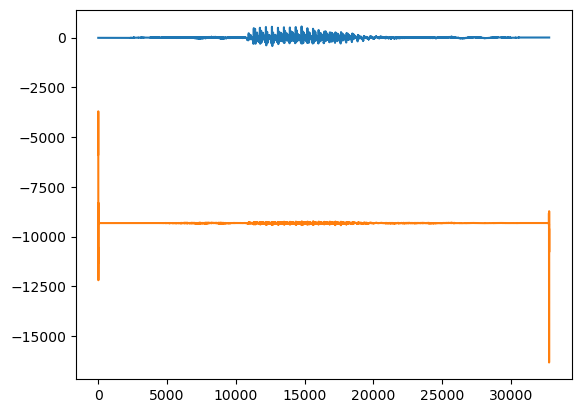

loss: 0.000056  [ 6400/24000]


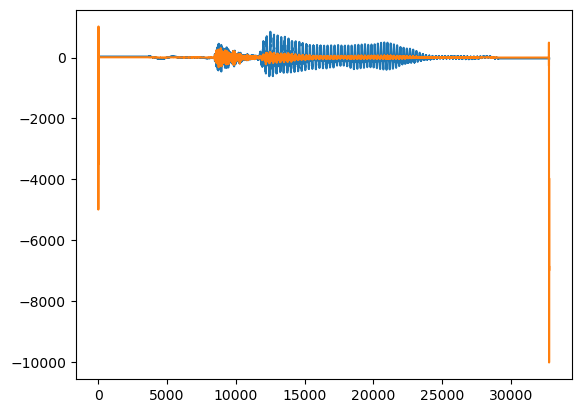

loss: 0.000063  [12800/24000]


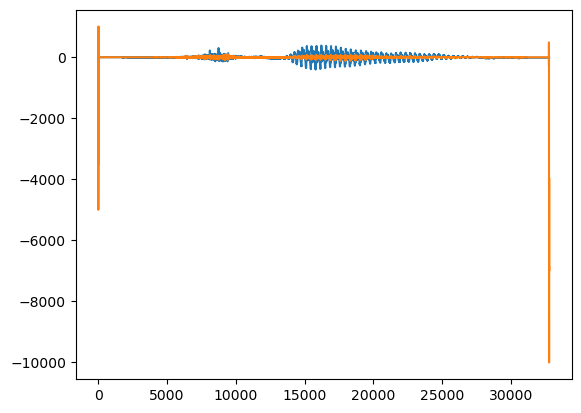

loss: 0.000041  [19200/24000]


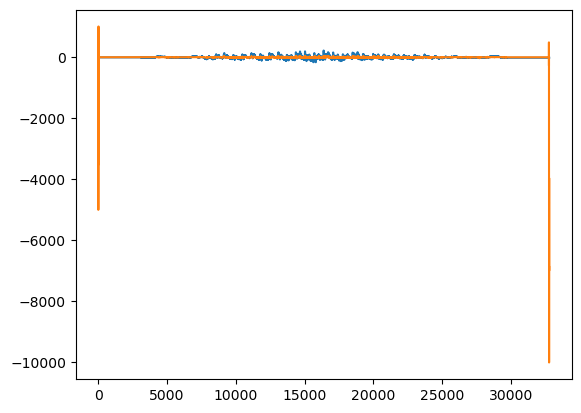

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7cf224b320>
Traceback (most recent call last):
Exception ignored in:   File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7cf224b320>    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7cf224b320>
self._shutdown_workers()Traceback (most recent call last):


  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Exception ignored in: Traceback (most recent call last):
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7cf224b320>self._shutdown_workers()      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
if w.is_alive():

Traceback (most recent call last):

   

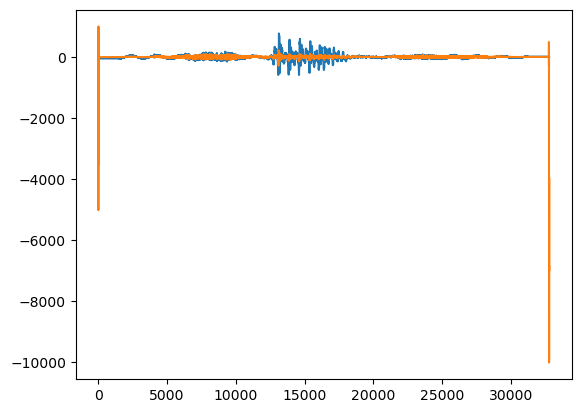

Test Error: 
 Avg loss: 0.000049 
 Avg MSE: 0.000049 


Epoch 2
-------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000043  [    0/24000]


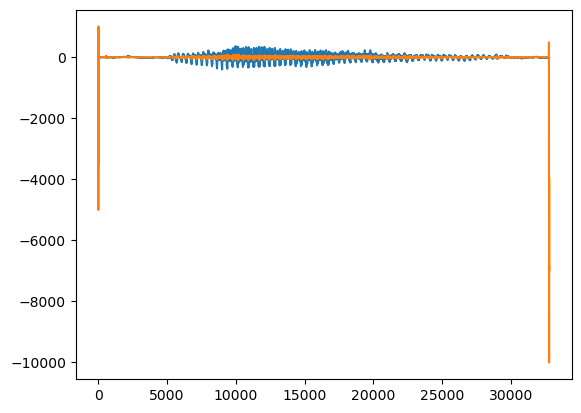

loss: 0.000040  [ 6400/24000]


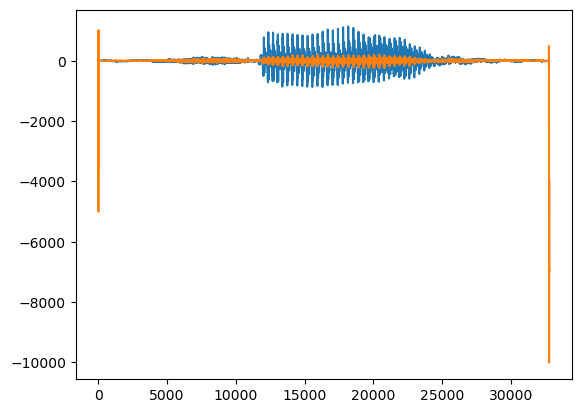

loss: 0.000052  [12800/24000]


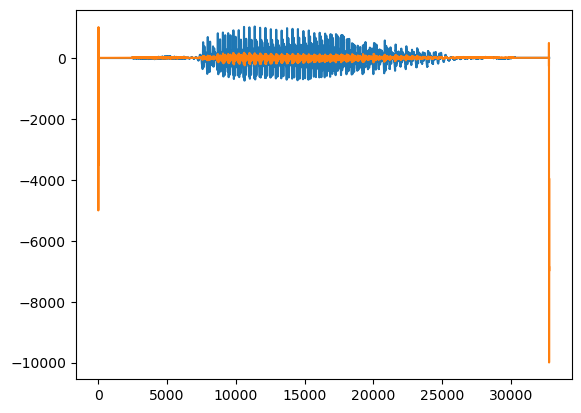

loss: 0.000039  [19200/24000]


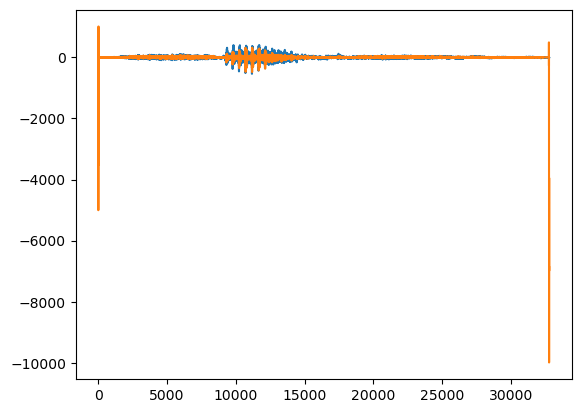

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

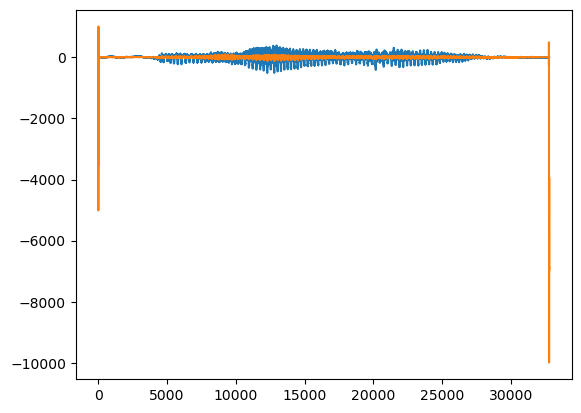

Test Error: 
 Avg loss: 0.000049 
 Avg MSE: 0.000049 


Epoch 3
-------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000053  [    0/24000]


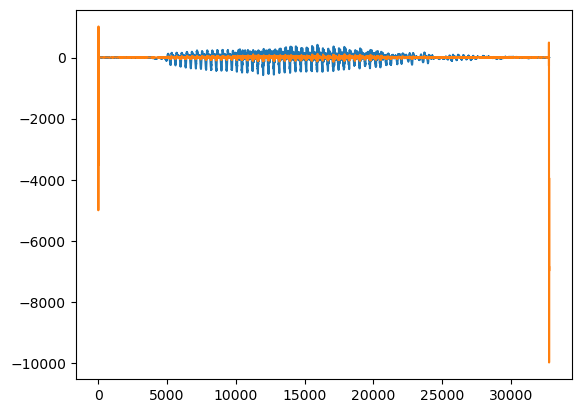

loss: 0.000038  [ 6400/24000]


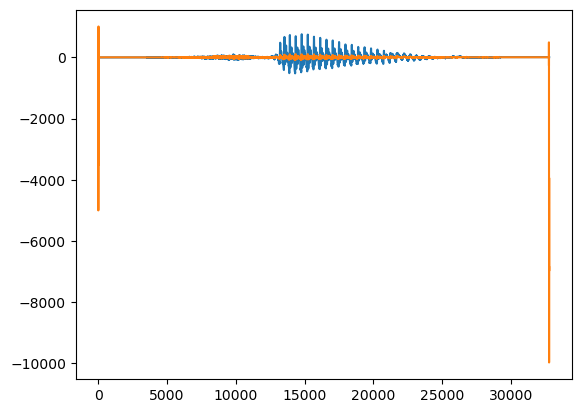

loss: 0.000039  [12800/24000]


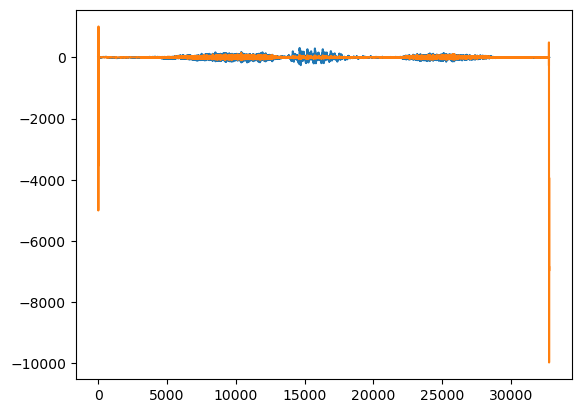

loss: 0.000044  [19200/24000]


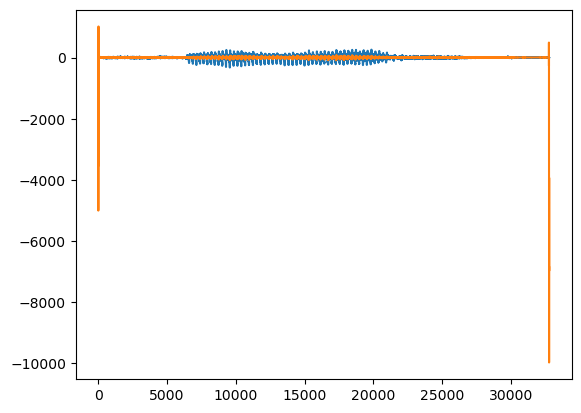

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

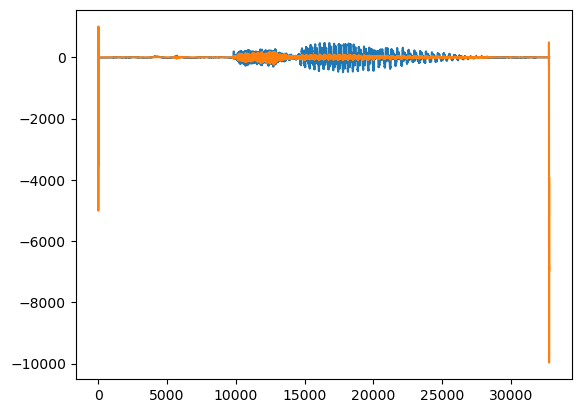

Test Error: 
 Avg loss: 0.000048 
 Avg MSE: 0.000048 


Epoch 4
-------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000079  [    0/24000]


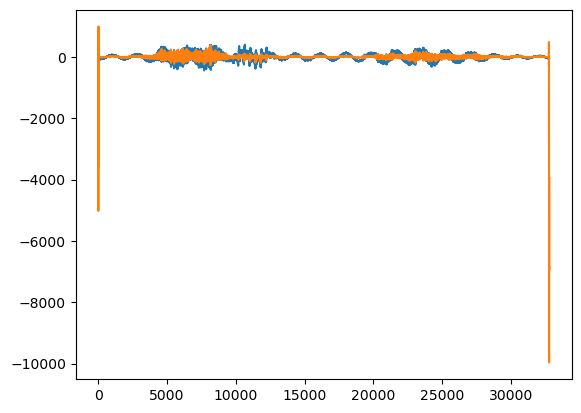

loss: 0.000058  [ 6400/24000]


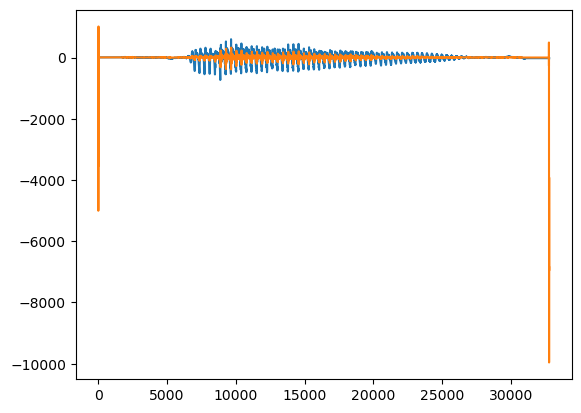

loss: 0.000047  [12800/24000]


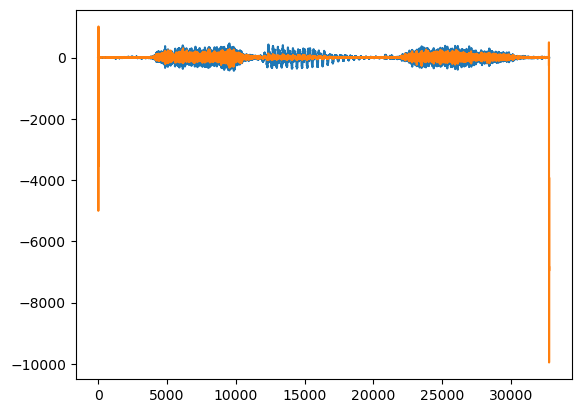

loss: 0.000048  [19200/24000]


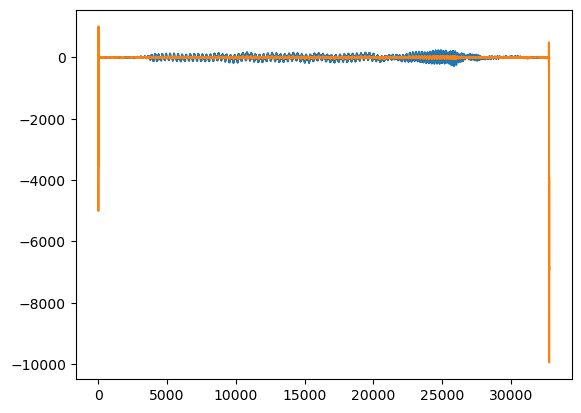

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

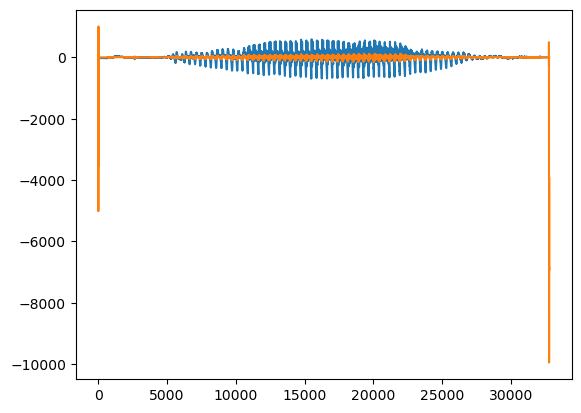

Test Error: 
 Avg loss: 0.000047 
 Avg MSE: 0.000047 


Epoch 5
-------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000033  [    0/24000]


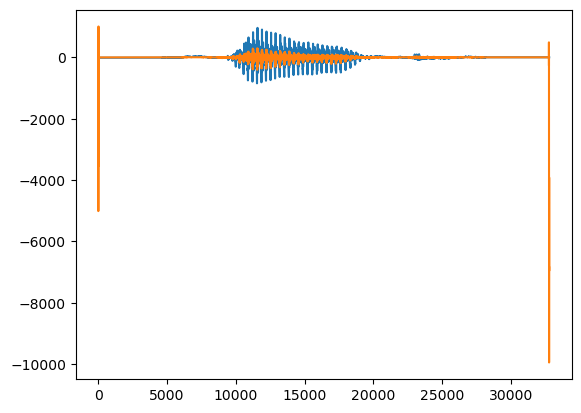

loss: 0.000055  [ 6400/24000]


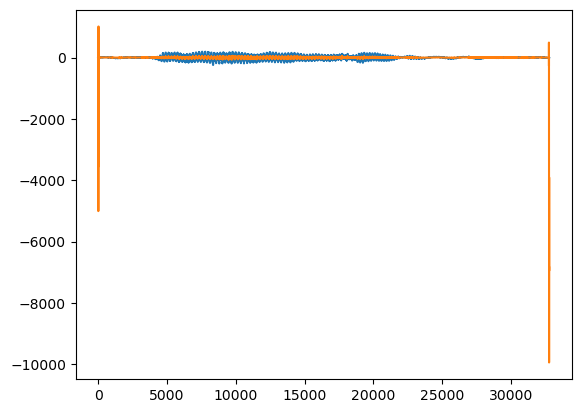

loss: 0.000033  [12800/24000]


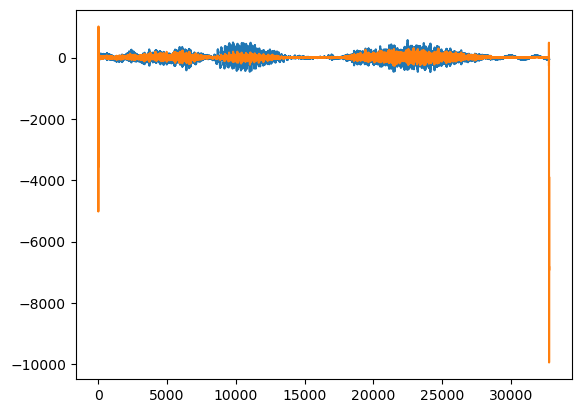

loss: 0.000034  [19200/24000]


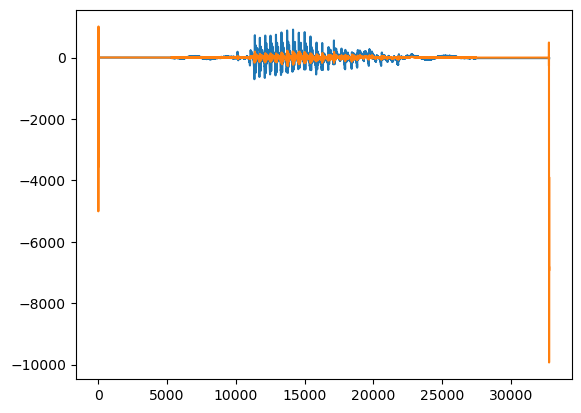

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

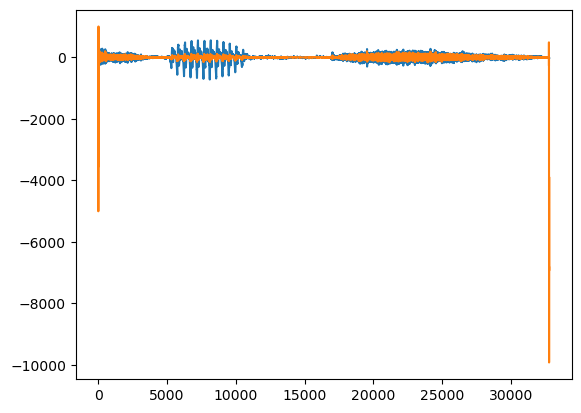

Test Error: 
 Avg loss: 0.000047 
 Avg MSE: 0.000047 


Epoch 6
-------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000036  [    0/24000]


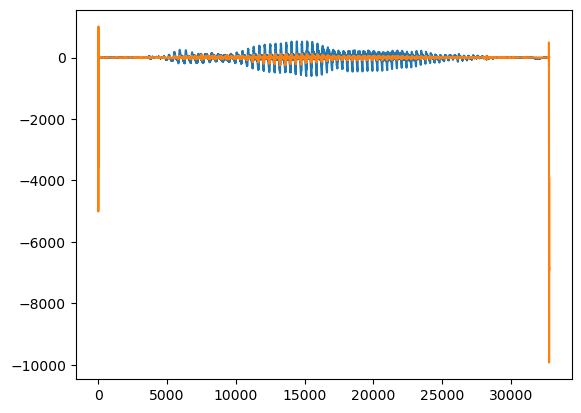

loss: 0.000033  [ 6400/24000]


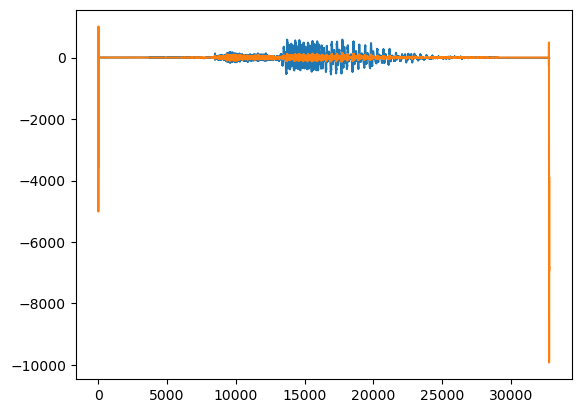

loss: 0.000042  [12800/24000]


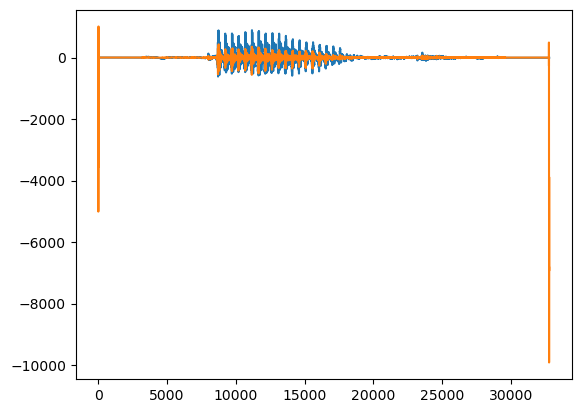

loss: 0.000061  [19200/24000]


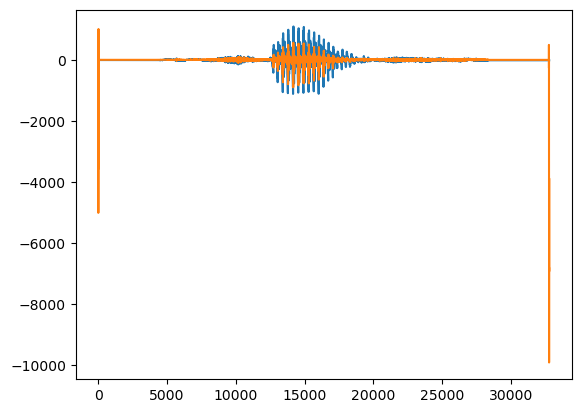

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

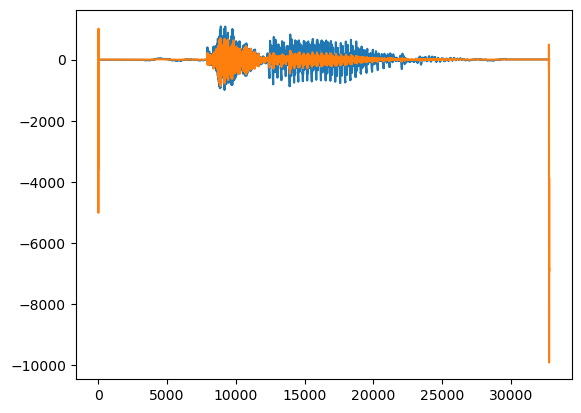

Test Error: 
 Avg loss: 0.000046 
 Avg MSE: 0.000046 


Epoch 7
-------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000039  [    0/24000]


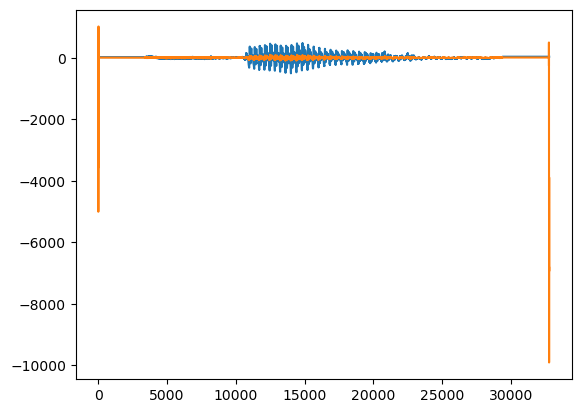

loss: 0.000035  [ 6400/24000]


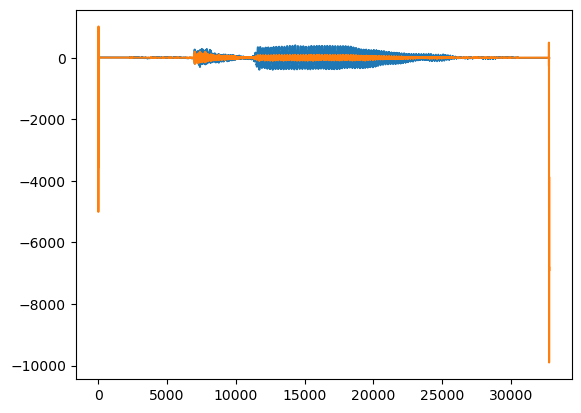

loss: 0.000055  [12800/24000]


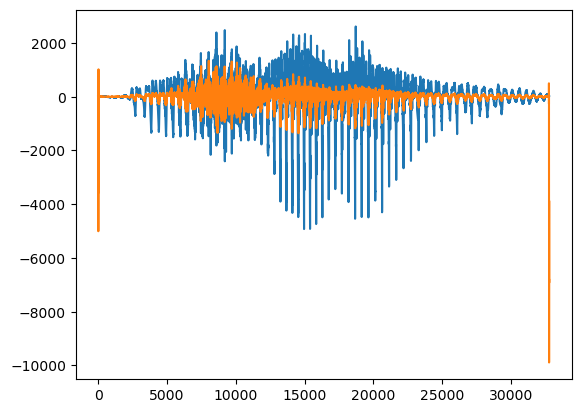

loss: 0.000033  [19200/24000]


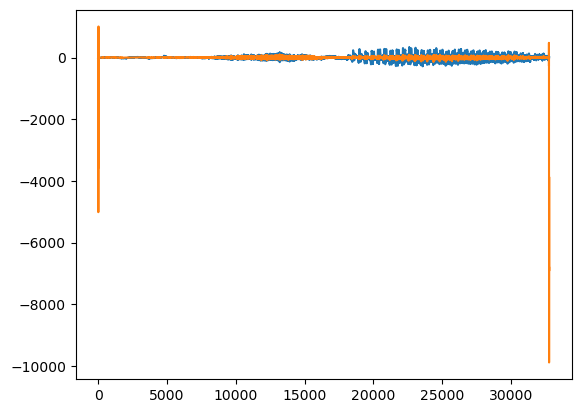

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

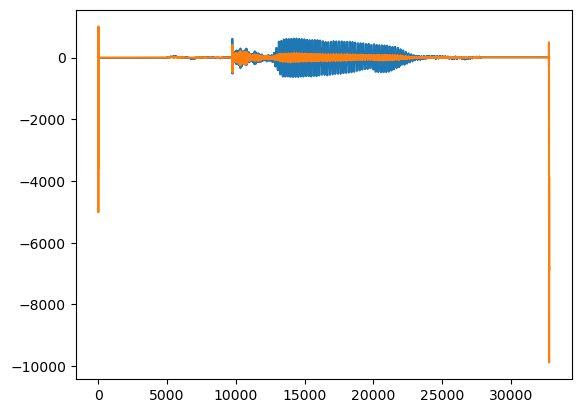

Test Error: 
 Avg loss: 0.000045 
 Avg MSE: 0.000045 


Epoch 8
-------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000041  [    0/24000]


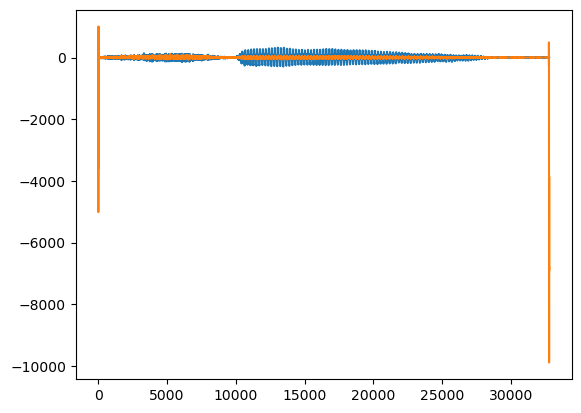

loss: 0.000055  [ 6400/24000]


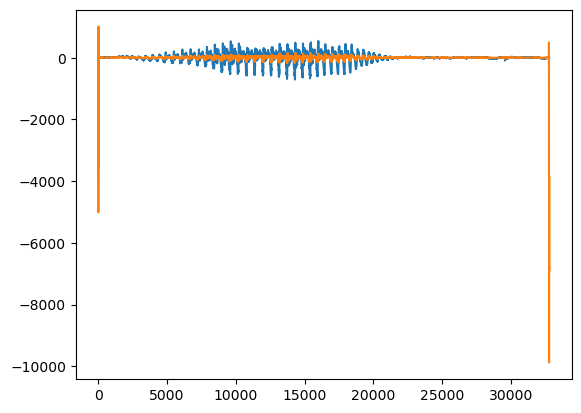

loss: 0.000033  [12800/24000]


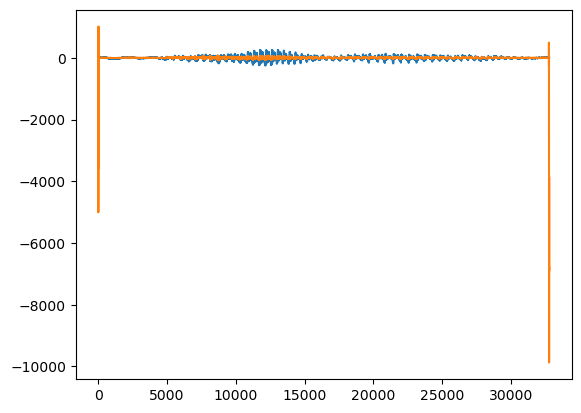

loss: 0.000045  [19200/24000]


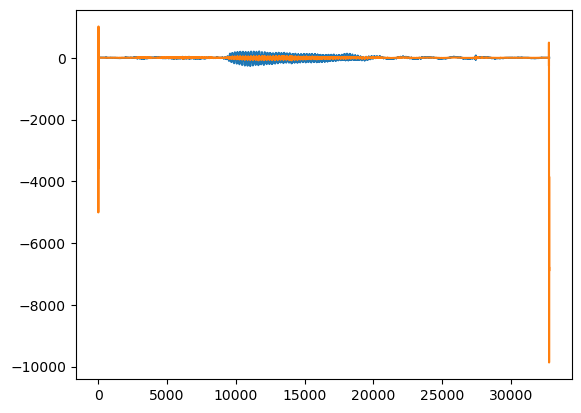

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

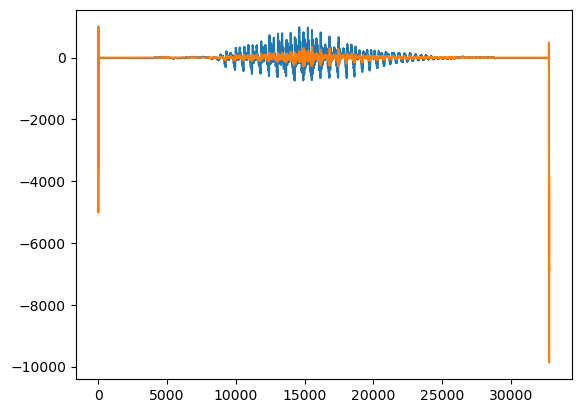

Test Error: 
 Avg loss: 0.000045 
 Avg MSE: 0.000045 


Epoch 9
-------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000032  [    0/24000]


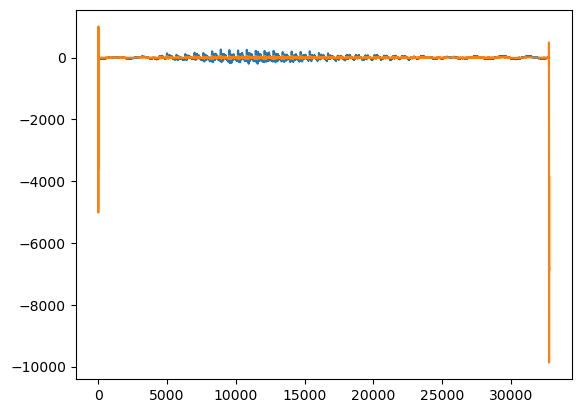

loss: 0.000070  [ 6400/24000]


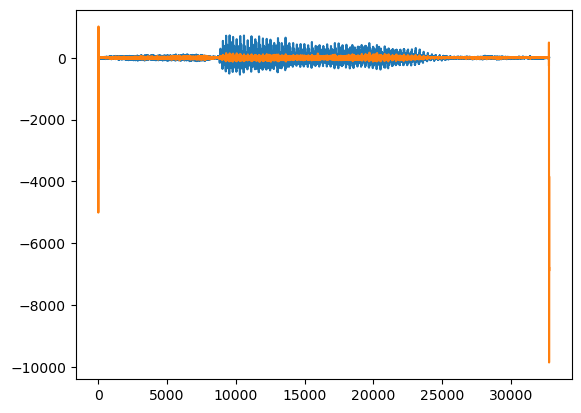

loss: 0.000031  [12800/24000]


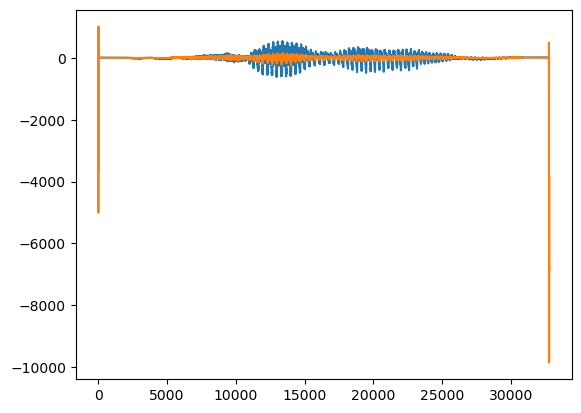

loss: 0.000050  [19200/24000]


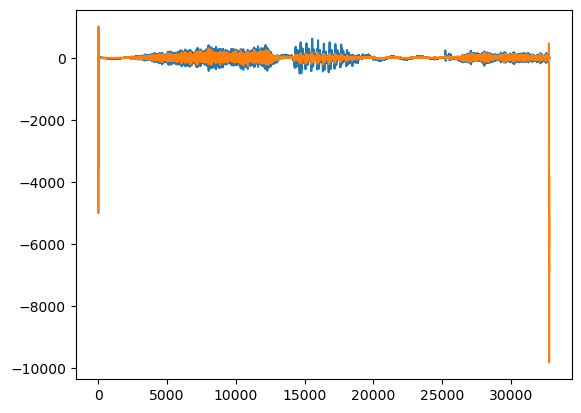

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

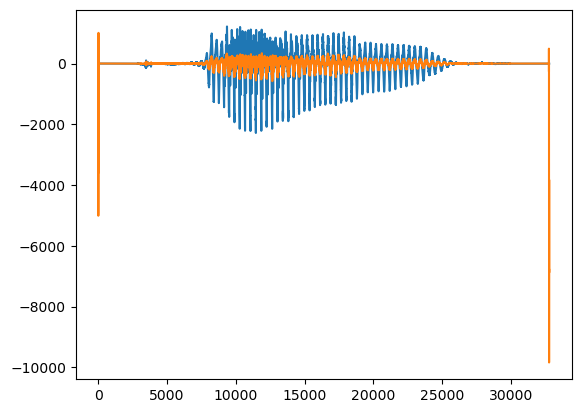

Test Error: 
 Avg loss: 0.000044 
 Avg MSE: 0.000044 


Epoch 10
-------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 0.000038  [    0/24000]


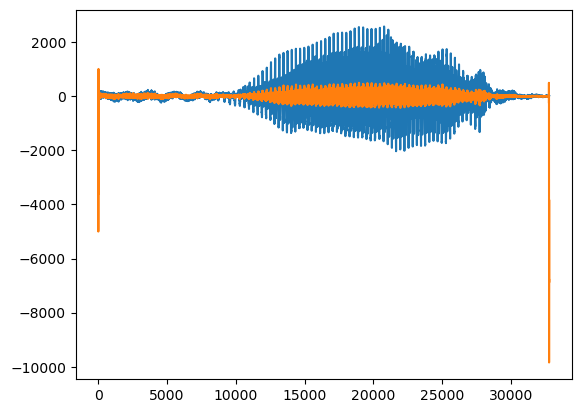

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_23/2157246744.py", line 6, in <module>
    train(dataloader_train, model, loss_fn, optimizer)
  File "/tmp/ipykernel_23/3852687271.py", line 4, in train
    for batch, (sample, label, _) in enumerate(data_loader):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 628, in __next__
    data = self._next_data()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _next_data
    idx, data = self._get_data()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1282, in _get_data
    success, data = self._try_get_data()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1120, in _try_get_data
    data = self._data_queue.get(timeout=timeout

TypeError: object of type 'NoneType' has no len()

In [85]:
epochs = 20

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    
    train(dataloader_train, model, loss_fn, optimizer)
    test(dataloader_test, model, loss_fn)
    print()

print("Done!")

In [80]:
del model, sample, label

NameError: name 'sample' is not defined

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = self._build_encoder()
        self.decoder = self._build_decoder()

    def forward(self, x):
        x = x.float()
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def _build_encoder(self):
        # encoder with
        return nn.Sequential(
            # 32768 * 1
            nn.Conv1d(1, 32, kernel_size=9, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(32, 64, kernel_size=9, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 128, kernel_size=9, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(128, 256, kernel_size=9, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            # global average pooling
            nn.AdaptiveAvgPool1d(1),
            # reshape
            nn.Flatten(),
            # linear
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
        )

    def _build_decoder(self):
        return nn.Sequential(
            # 512
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            # reshape
            nn.Unflatten(1, (256, 1)),
            nn.Upsample(size=2048),
            nn.ConvTranspose1d(256, 128, kernel_size=9, stride=1, padding=0),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(128, 64, kernel_size=9, stride=1, padding=0),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 32, kernel_size=9, stride=1, padding=0),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(32, 1, kernel_size=9, stride=1, padding=0),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
        )
